In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
plt.style.use("asludds")
from scipy.optimize import newton
from tqdm import tqdm

from SOA_model import SOA

# Guidance from Molly

1. Calculate mirror losses and reflectivities on both sides of the gain section

    For our mirror, it’s reasonable/conservative to assume 0.3dB loss

2. Calculate threshold gain from mirror reflectivities (2*Gth – 2*other cavity loss = R1+R2 with everything in dB)

    You can ignore Psat here because the power will be low

3. Use the SOA model and the result of step 1 to calculate Ith
4. Use the mirror and other cavity losses (in inverse cm or meters – these are modal values) to calculate the differential efficiency

    Eta_d = eta_i*alpha_m/(alpha_i+alpha_m)
    Eta_i is the injection efficiency I communicated earlier
    Alpha_i is the propagation loss in the cavity – you can use 8 inverse cm in the gain section.  It’s a weighted average over the cavity length…
    Alpha_m = 1/L ln (1/R) – R is the total power reflectivity the gain section sees, so it’s going to be your front mirror * 1.

5. Calculate LI curve without heating:

    Pout = eta_d * h*nu/q  * (I-Ith)

6. For the current of interest, calculate power dissipated and associated self-heating
Repeat 2-6 for new temperature until the solution converges

Gain threshold (dB):  6.754400086720375
0.21113488271263073
Coupling loss (dB):  3.979400086720376
398.7841269692314
234.9463415061936
Probability photon lost to output:  0.19598719754505378
Differential efficiency:  0.13719103828153764


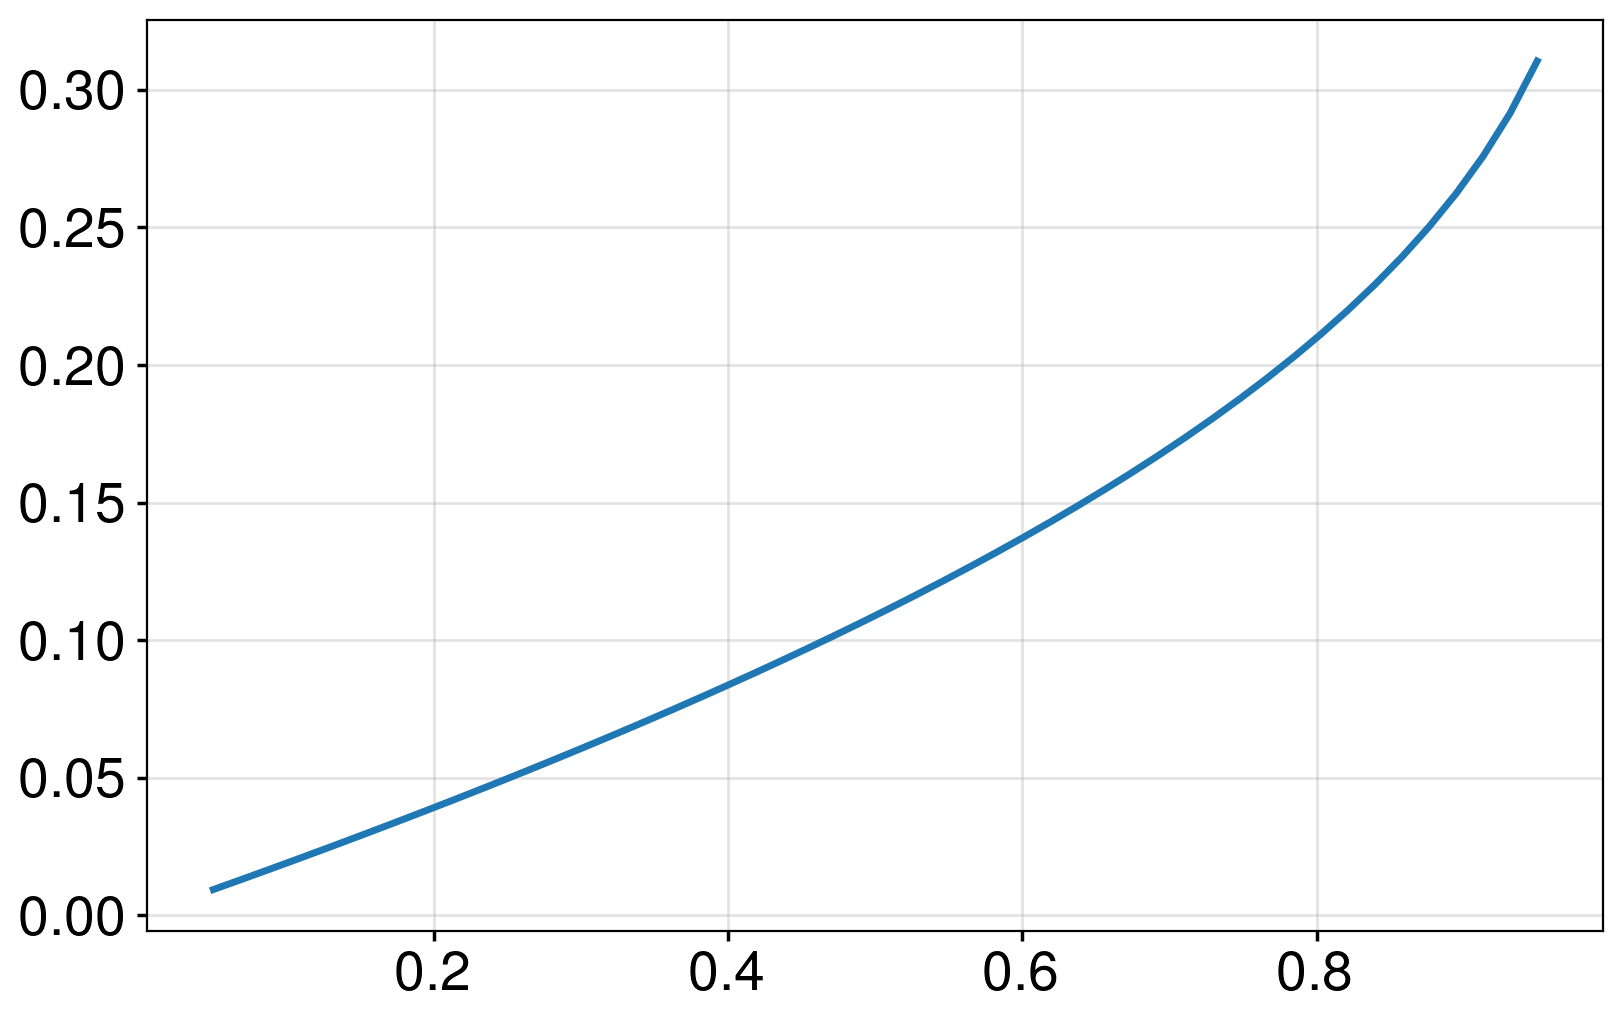

In [2]:
class laser_output_power():
    def __init__(
        self,
        Lsoa = 900e-6, #In meters
        W=2.7e-6, #In meters
        J = 7, #kA/cm^2,
        Tamb = 70, #Ambient temperature in Celsius
        Pcoupling = 0.6 #Fraction of light outcoupled
        ):
        self.Lsoa = Lsoa
        self.W = W
        self.J = J #Current density in SOA in units of kA/cm^2
        self.I = self.J * 1e7 *  self.W * self.Lsoa #Factor of 1E7 corrects for 
        self.Pcoupling = Pcoupling
        self.Tamb = Tamb
        self.wl = 1310e-9
        self.cavity_length_external_to_SOA = 3e-3
        self.expected_longitudinal_cavity_length = self.cavity_length_external_to_SOA + self.Lsoa
        self.deltaT = 0 #Change in junction temperature

    def step1_2(self):
        self.EC_loss_dB = 2.0
        self.EC_loss_linear = 10**(-self.EC_loss_dB/10)
        
        self.Pcoupling_dB = -10*np.log10(1 - self.Pcoupling)
        self.ring_loss_dB = 0.6
        self.ring_loss_linear = 10**(-self.ring_loss_dB/10)

        self.SiN_loss_dB = 1e-3 * 30 #Loss from extra SiN waveguides on 45CLO, 1mm * 30dB/m
        self.Si_loss_dB  = 500e-6 * 100 #Loss from extra Si waveguides on PH18DA, 500um * 100dB/m
        self.sagnac_loss_dB = 0.090 #Loss of y-junction in sagnac reflector on PH18DA, 98% reflection
        self.XPS_YJ_loss_dB = 0.35 #Loss of XPS w/NLA + nit yjunction on 45CLO

        # self.total_round_trip_loss_dB = 2*self.EC_loss_dB + self.ring_loss_dB + 2*self.Pcoupling_dB
        self.gain_threshold_dB = self.ring_loss_dB/2 + self.EC_loss_dB + self.XPS_YJ_loss_dB + self.sagnac_loss_dB / 2 +  self.Si_loss_dB + self.SiN_loss_dB + self.Pcoupling_dB

    def step3(self):
        # Use the SOA model and the result of step 1 to calculate Ith
        current_density_sweep = np.linspace(1,7,num=1000)
        gain_storage = []
        for J in current_density_sweep:
            soa = SOA(T=self.Tamb + self.deltaT,J=J,L=self.Lsoa*1e6 - 460,wl=self.wl*1e9)
            gain_storage.append(soa.g0)

        gain_storage = np.array(gain_storage)

        self.Jth = current_density_sweep[np.argmin(np.abs(gain_storage - 10**(self.gain_threshold_dB/10)))]
        # print("Threshold current density: ", self.Jth)

    def step4(self):
        self.etai = 0.7 #Based on data from Molly email
        self.alpha_passive_losses = -1/self.expected_longitudinal_cavity_length * np.log(10**(-self.gain_threshold_dB/10))
        self.alpha_coupling       = -1/self.expected_longitudinal_cavity_length * np.log(1-self.Pcoupling)
        self.alpha_SOA            = 800 #Soa loss rate in 1/m

        self.photon_lost_to_output = self.alpha_coupling/(self.alpha_passive_losses + self.alpha_SOA)
        self.eta_d = self.etai * self.photon_lost_to_output

    def step5(self):
        self.hnu = 1.52e-19 #1310nm photon energy
        self.q = 1.602e-19
        self.Pout = self.eta_d * self.hnu/self.q * (self.J - self.Jth) * 1e7 * self.W * self.Lsoa
        if self.Pout <0:
            self.Pout = 0 #Clamp output power

    def step6(self):
        # For the current of interest, calculate power dissipated and associated self-heating
        self.Zt = 108*1100e-6/self.Lsoa #C/W @ 1100um length
        self.V=0.98+2.8*self.I*(1100*1e-6/self.Lsoa)
        SOA_transmission = np.exp(-self.alpha_SOA * self.Lsoa)
        # print("SOA transmission: ", SOA_transmission)
        # print("Scattering + out-coupling losses: ",10**(-self.gain_threshold_dB/10) )
        Q = SOA_transmission/(10**(-self.gain_threshold_dB/10) + SOA_transmission)
        # print("Q: ", Q)

                    
        # self.Pd = self.I*self.V - self.I * self.etai * (self.alpha_passive_losses + self.alpha_coupling)/(self.alpha_passive_losses + self.alpha_coupling + self.alpha_SOA)
        self.Pd = self.I*self.V - self.hnu/self.q * self.I * self.etai*(1-Q)
        self.deltaT = self.Zt * self.Pd

    def run_until_convergence(self):
        previous_deltaT = -1e6
        minimum_number_of_iterations = 10
        iteration_count = 0
        while (abs(self.deltaT - previous_deltaT) > 1e-6) or (iteration_count < minimum_number_of_iterations):
            # print(abs(self.deltaT - previous_deltaT))
            # print(iteration_count)
            previous_deltaT = self.deltaT
            self.step1_2()
            self.step3()
            self.step4()
            self.step5()
            self.step6()
            iteration_count += 1
        return self.Pout

temp = laser_output_power()
temp.step1_2()
temp.step3()
temp.step4()
print("Gain threshold (dB): ", temp.gain_threshold_dB)
print(10**(-temp.gain_threshold_dB/10))
print("Coupling loss (dB): ", temp.Pcoupling_dB)
print(temp.alpha_passive_losses)
print(temp.alpha_coupling)
print("Probability photon lost to output: ", temp.photon_lost_to_output)
print("Differential efficiency: ",temp.eta_d)

#Find the optimal Pcoupling
Pcoupling_sweep = np.linspace(0.05,0.95,num=50)
output_power_storage = []
for Pcoupling in Pcoupling_sweep:
    laser_out_object = laser_output_power(Pcoupling = Pcoupling)
    laser_out_object.run_until_convergence()
    output_power_storage.append(laser_out_object.eta_d)
    # output_power_storage.append(laser_out_object.run_until_convergence())

output_power_storage = np.array(output_power_storage)

plt.figure()
plt.plot(Pcoupling_sweep,output_power_storage)

Current density sweep: 100%|██████████| 7/7 [01:46<00:00, 15.27s/it]


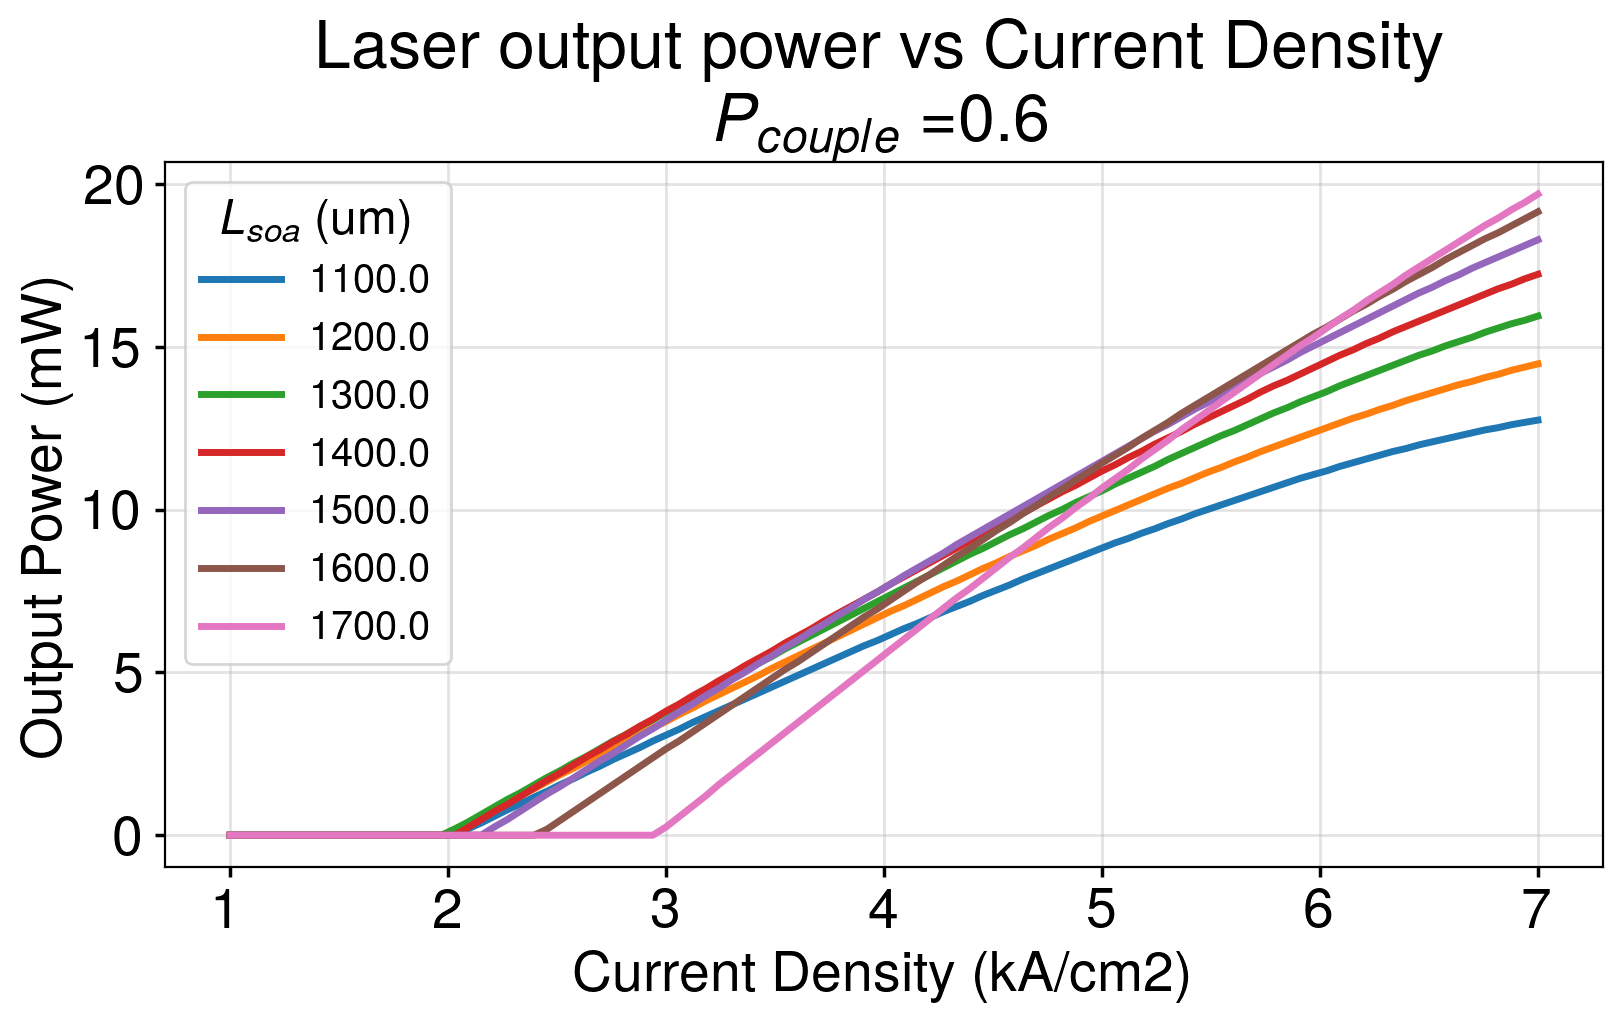

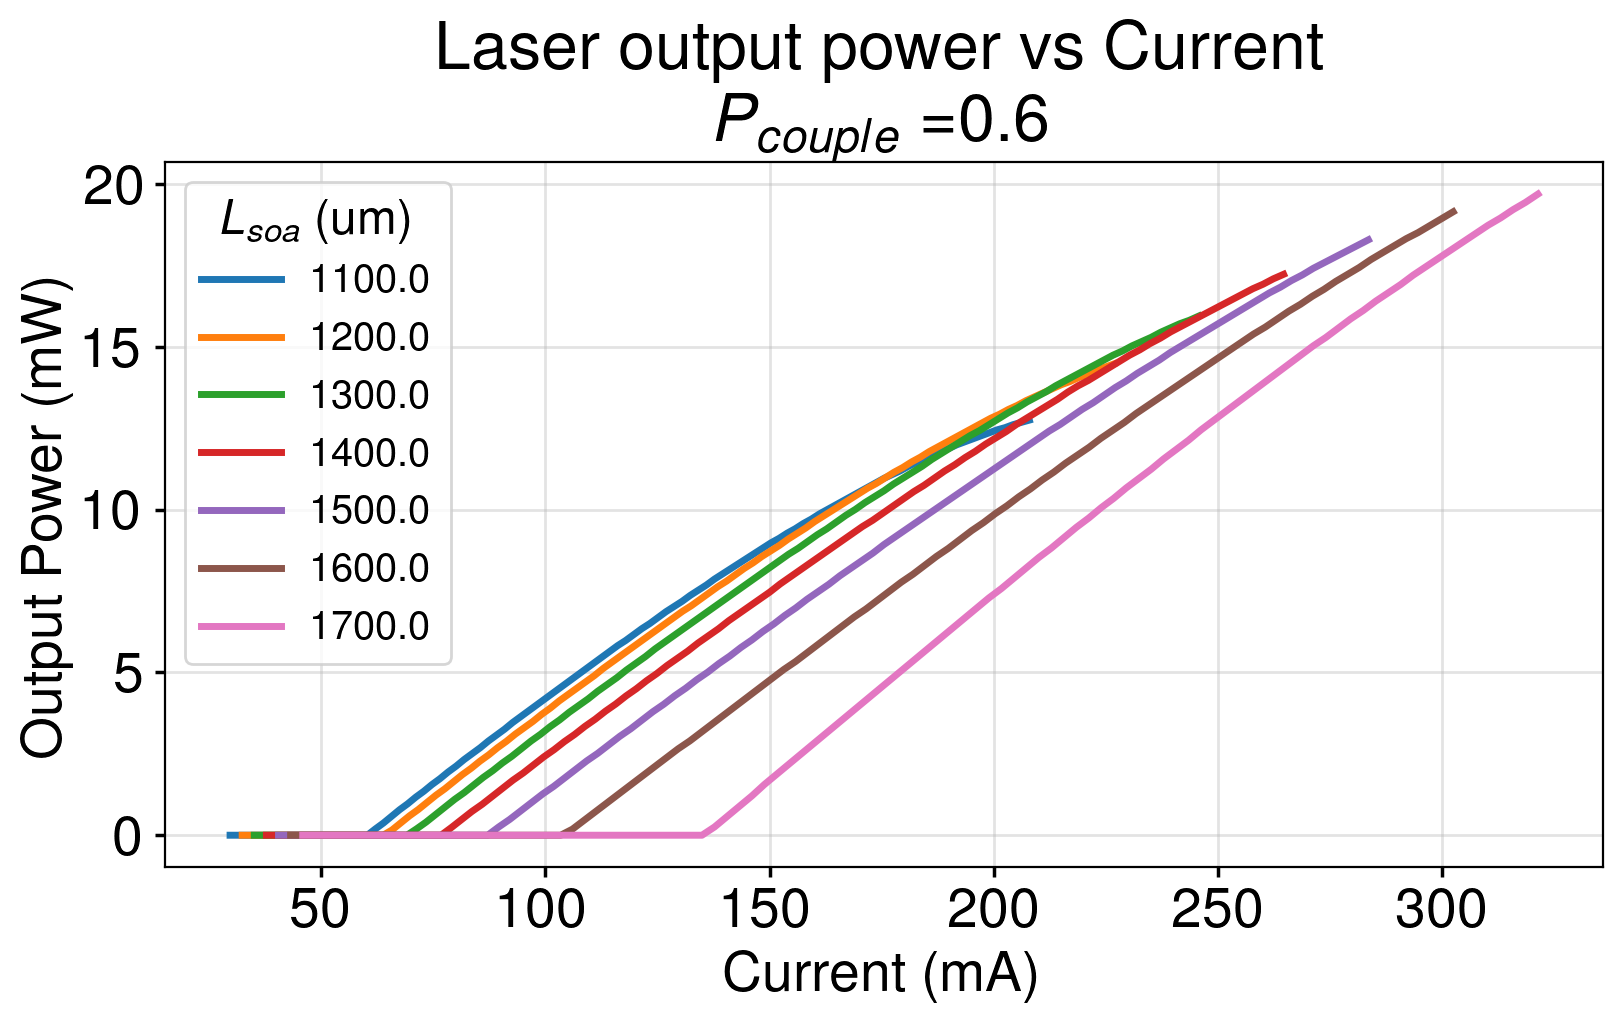

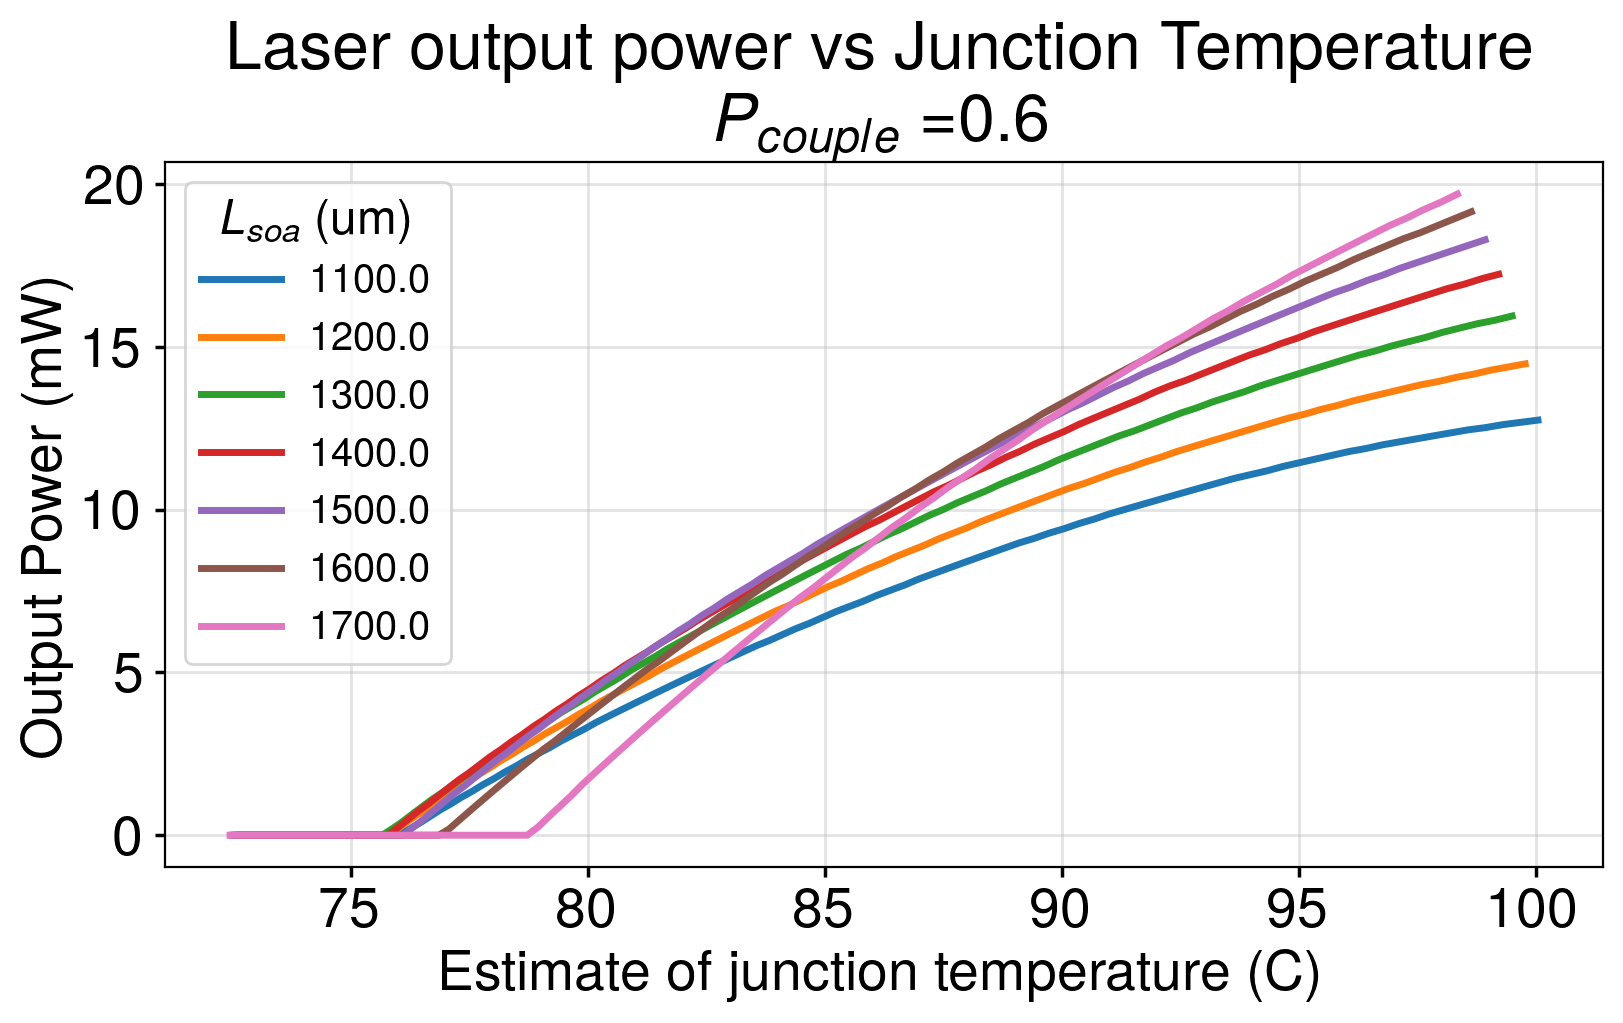

In [3]:
#Sweep drive current, measure output power
L_to_test = np.array([1100e-6,1200e-6,1300e-6,1400e-6,1500e-6,1600e-6,1700e-6])
J_sweep = np.linspace(1,7,num=100)
Pcouple = 0.6
current_storage = []
output_power_storage = []
junction_temperature_estimate_storage = []
for L in tqdm(L_to_test,desc='Current density sweep'):
    temp_output_power_storage = []
    temp_current_storage      = []
    temp_junction_temp_stor   = []
    for J in J_sweep:
        laser_out_object = laser_output_power(J = J,Lsoa=L,Pcoupling=Pcouple)
        laser_out_object.run_until_convergence()
        temp_output_power_storage.append(laser_out_object.Pout)
        temp_current_storage.append(laser_out_object.I)
        temp_junction_temp_stor.append(laser_out_object.Tamb + laser_out_object.deltaT)
    output_power_storage.append(temp_output_power_storage)
    current_storage.append(temp_current_storage)
    junction_temperature_estimate_storage.append(temp_junction_temp_stor)

output_power_storage = np.array(output_power_storage)
current_storage      = np.array(current_storage)
junction_temperature_estimate_storage = np.array(junction_temperature_estimate_storage)

plt.figure()
plt.plot(J_sweep,output_power_storage.T*1e3)
plt.xlabel("Current Density (kA/cm2)")
plt.ylabel("Output Power (mW)")
plt.legend(L_to_test*1e6,title=r'$L_{soa}$ ' + '(um)')
plt.title("Laser output power vs Current Density \n " + r"$P_{couple} = $" + str(np.round(laser_out_object.Pcoupling,2)))
plt.show()


plt.figure()
plt.plot(current_storage.T*1e3,output_power_storage.T*1e3)
plt.xlabel("Current (mA)")
plt.ylabel("Output Power (mW)")
plt.legend(L_to_test*1e6,title=r'$L_{soa}$ ' + '(um)')
plt.title("Laser output power vs Current \n " + r"$P_{couple} = $" + str(np.round(laser_out_object.Pcoupling,2)))
plt.show()

plt.figure()
plt.plot(junction_temperature_estimate_storage.T,output_power_storage.T*1e3)
plt.xlabel("Estimate of junction temperature (C)")
plt.ylabel("Output Power (mW)")
plt.legend(L_to_test*1e6,title=r'$L_{soa}$ ' + '(um)')
plt.title("Laser output power vs Junction Temperature \n " + r"$P_{couple} = $" + str(np.round(laser_out_object.Pcoupling,2)))
plt.show()

Pcouple sweep for length vs output power sweep: 100%|██████████| 5/5 [01:14<00:00, 14.93s/it]


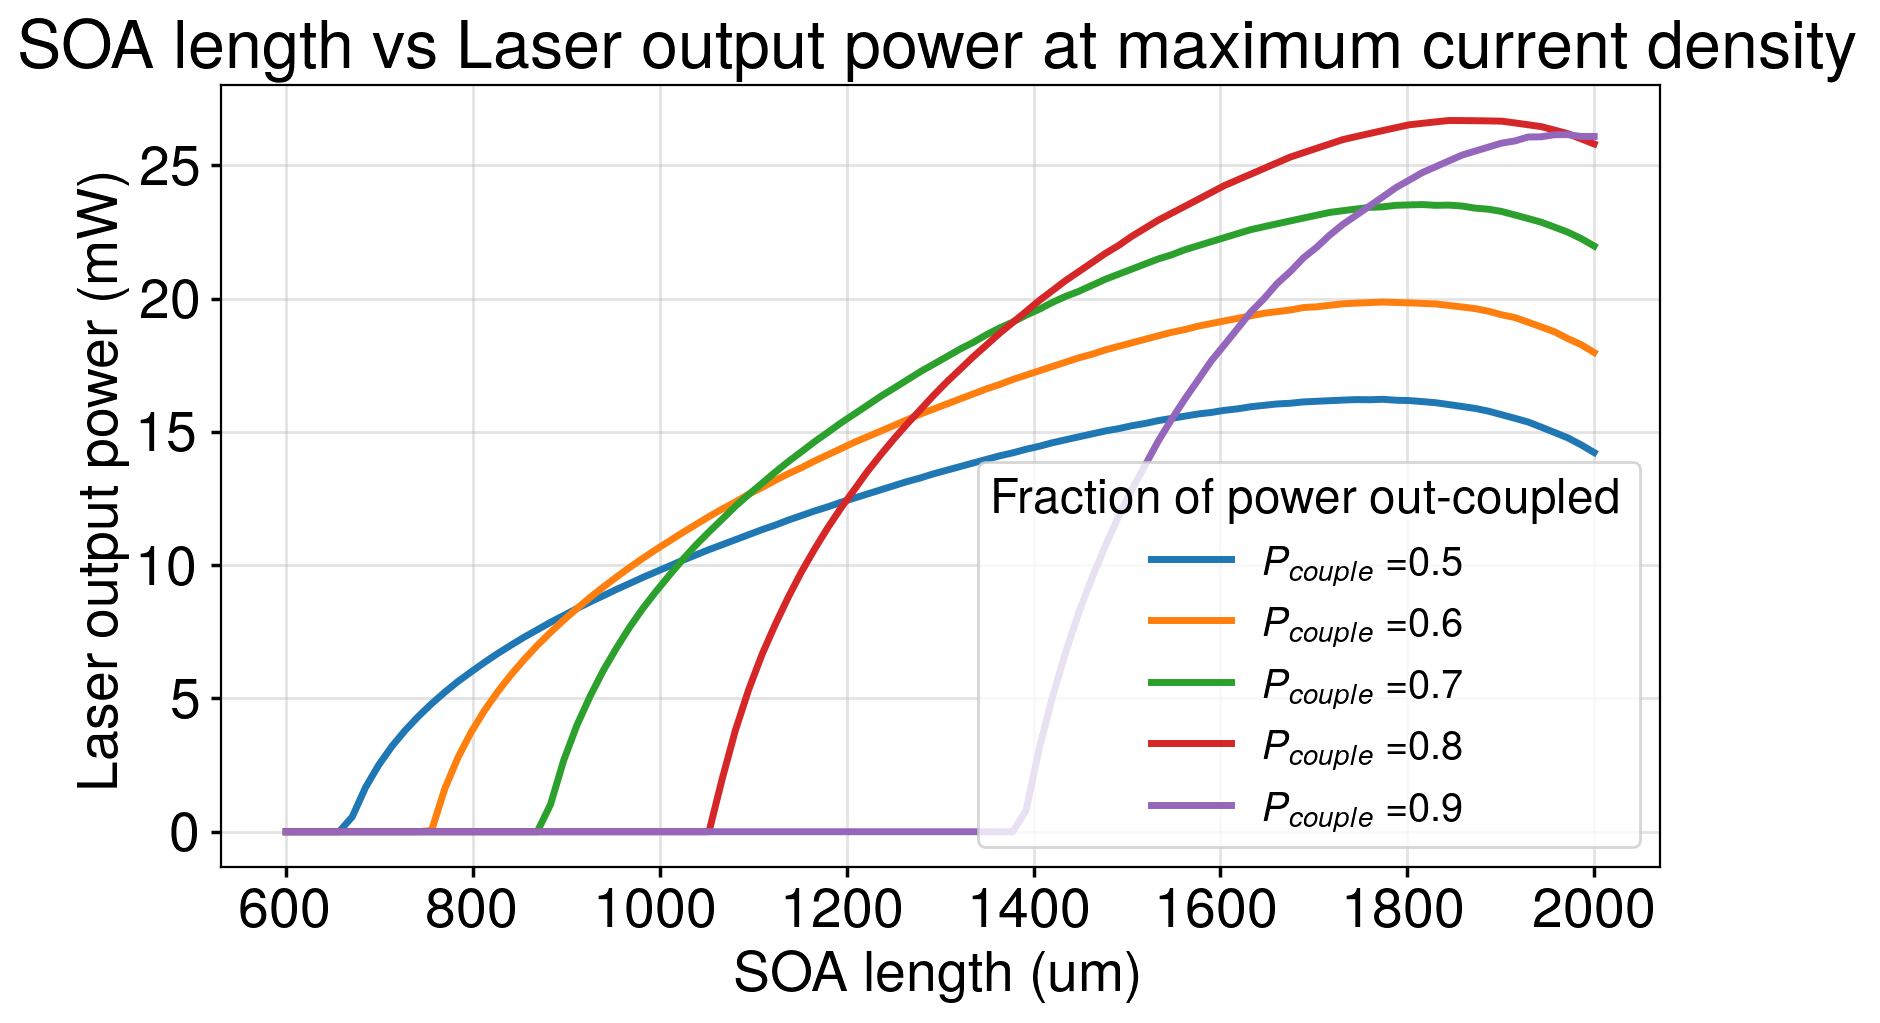

In [4]:

Pcouple_sweep = [0.5,0.6,0.7,0.8,0.9]

Lsweep = np.linspace(600e-6,2000e-6,num=100)
output_power_storage = []
for Pcouple in tqdm(Pcouple_sweep,desc='Pcouple sweep for length vs output power sweep'):
    temp_out_power_storage = []
    for L in Lsweep:
        laser_out_object = laser_output_power(J=7,Lsoa = L,Pcoupling = Pcouple)
        temp_out_power_storage.append(laser_out_object.run_until_convergence())
    output_power_storage.append(temp_out_power_storage)
output_power_storage = np.array(output_power_storage)

plt.figure()
plt.plot(Lsweep*1e6,output_power_storage.T*1e3)
plt.xlabel("SOA length (um)")
plt.ylabel("Laser output power (mW)")
plt.title("SOA length vs Laser output power at maximum current density")
plt.legend([r"$P_{couple} = $" + str(round(i,2)) for i in Pcouple_sweep],title="Fraction of power out-coupled")